In [1]:
import sys ; sys.path.append('../')
from load import RIR
from acoustic_params import Acoustic_params
from filterbank import Filterbank
from scipy import stats
import librosa
import numpy as np
import matplotlib.pyplot as plt

params = {'fs' : 16000,
          'bands' : [125, 250, 500, 1000, 2000, 4000],
          'bandsize' : 1,
          'order' : 4,
          'f_length': 16384,'power' : True}

In [7]:
#impulso = RIR('../files/rir.wav', fs=params['fs'])
impulso = RIR('/mnt/datasets/impulsos/reales/C4DM/classroomOmni/Omni/00x15y.wav', fs=params['fs'])
a_params = Acoustic_params(impulso.rir, impulso.fs)
filterbank = Filterbank(**params)
bands = filterbank.apply(impulso.rir)

In [8]:
init, end, factor = -5, -35, 2

In [9]:
def plotear_banda(axs, signal, label):
    axs.plot(signal, label=label)
    axs.legend()

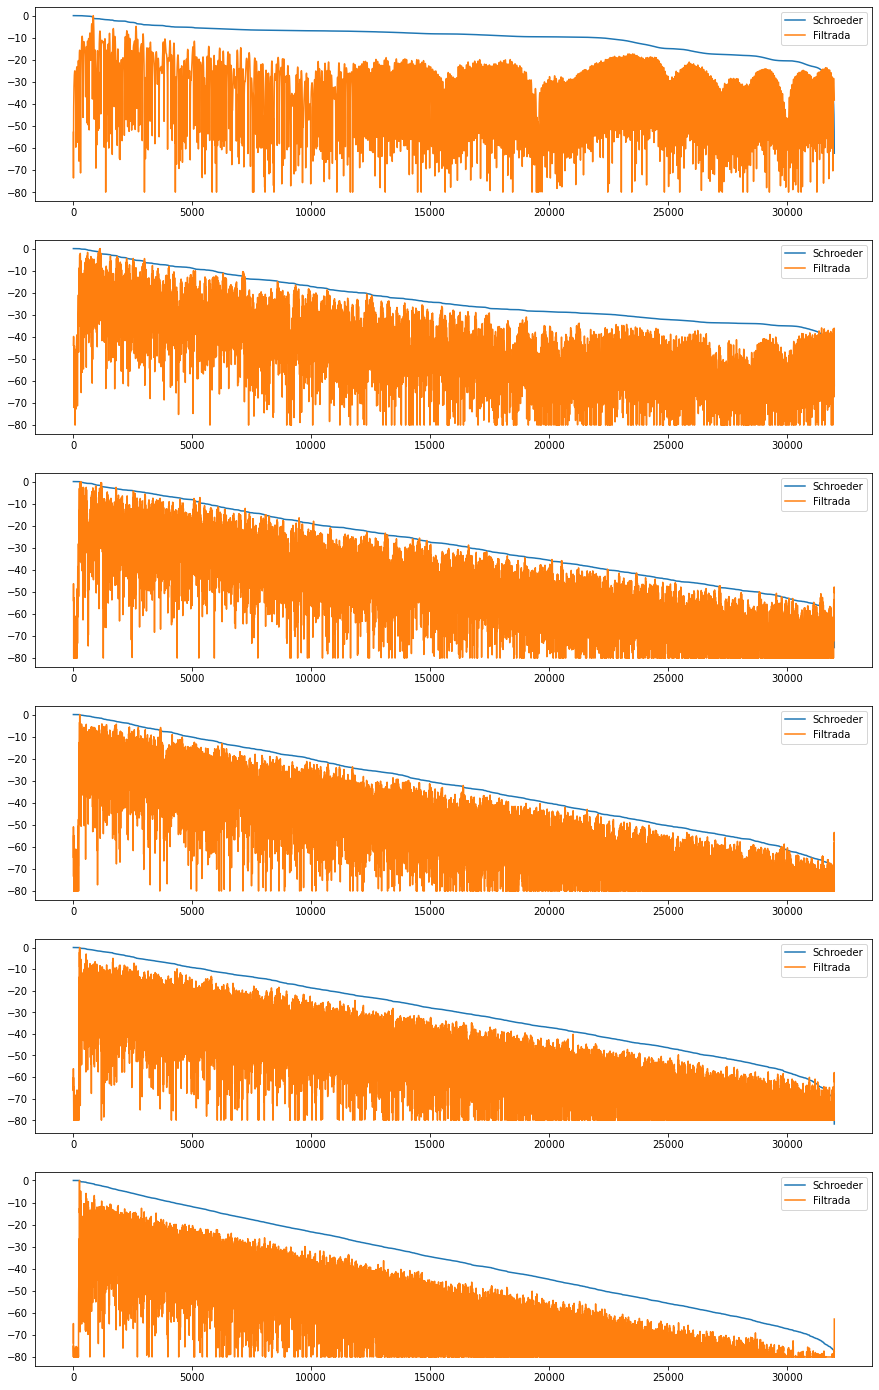

In [10]:
t60 = np.zeros(len(bands))                                                                                                         

fig, axs = plt.subplots(len(params['bands']), figsize=(15,25))

for band in range(len(bands)):                                                                                                      
    # Filtering signal                                                                                                              
    filtered_signal = bands[band] # Con mi filtro
    abs_signal = np.abs(filtered_signal) / np.max(np.abs(filtered_signal))                                                          

    #plotear_banda(axs[band], abs_signal, 'Filtrada')

    # Schroeder integration                                                                                                         
    sch = np.cumsum(abs_signal[::-1]**2)[::-1]                                                                                      
    sch_db = 10.0 * np.log10(sch / np.max(sch))                                                                                     
    plotear_banda(axs[band], sch_db, 'Schroeder')
    plotear_banda(axs[band], librosa.amplitude_to_db(abs_signal), 'Filtrada')
    
    # Linear regression                                                                                                             
    sch_init = sch_db[np.abs(sch_db - init).argmin()]                                                                               
    sch_end = sch_db[np.abs(sch_db - end).argmin()]                                                                                 
    init_sample = np.where(sch_db == sch_init)[0][0]                                                                                
    end_sample = np.where(sch_db == sch_end)[0][0]                                                                                  
    x = np.arange(init_sample, end_sample + 1) / params['fs']                                                                                 
    y = sch_db[init_sample:end_sample + 1]                                                                                          
    slope, intercept = stats.linregress(x, y)[0:2]                                                                                  

    # Reverberation time (T30, T20, T10 or EDT)                                                                                     
    db_regress_init = (init - intercept) / slope                                                                                    
    db_regress_end = (end - intercept) / slope                                                                                      
    t60[band] = factor * (db_regress_end - db_regress_init)                                                                         

In [11]:
t60

array([6.21181817, 3.4752879 , 2.08490223, 1.87477626, 2.01267183,
       1.65232344])

Conclusion: Necesito aplicar un metodo para estimar el piso de ruido. De otra forma, a curva se schroeder queda influenciada por toda la respuesta. Esto es un problema sobre todo a baja frecuencia, donde tengo presente cuestiones modales y donde probablemente no puedo generar mucha presion sonora a la hora de generar la respuesta. 

# Usando el filtro original

In [12]:
from acoustics.signal import bandpass
from acoustics.bands import _check_band_type, octave_low, octave_high, third_low, third_high

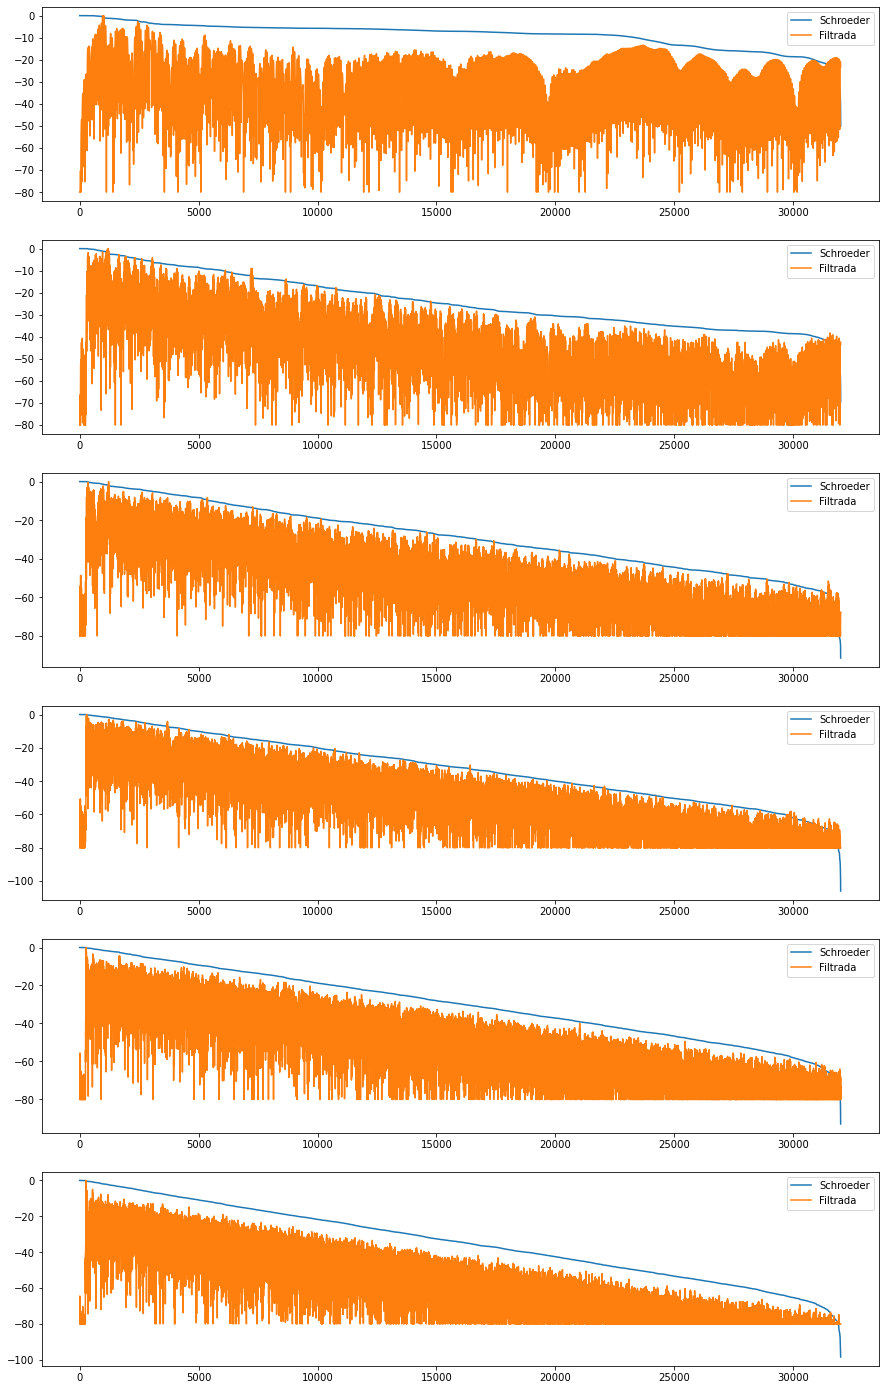

In [14]:
fs, raw_signal = impulso.fs, impulso.rir
rt = 't60'
bands = np.array(params['bands'])
fig, axs = plt.subplots(bands.shape[0], figsize=(15,25))

#Hacer mi propio chequeo de bandas                                                                                                  
band_type = _check_band_type(bands)                                                                                                 

if band_type == 'octave':                                                                                                           
    low = octave_low(bands[0], bands[-1])                                                                                           
    high = octave_high(bands[0], bands[-1])                                                                                         
elif band_type == 'third':                                                                                                          
    low = third_low(bands[0], bands[-1])                                                                                            
    high = third_high(bands[0], bands[-1])                                                                                          

rt = rt.lower()                                                                                                                     
if rt == 't30':                                                                                                                     
    init = -5.0                                                                                                                     
    end = -35.0                                                                                                                     
    factor = 2.0                                                                                                                    
elif rt == 't20':                                                                                                                   
    init = -5.0                                                                                                                     
    end = -25.0                                                                                                                     
    factor = 3.0                                                                                                                    
elif rt == 't10':                                                                                                                   
    init = -5.0                                                                                                                     
    end = -15.0                                                                                                                                  
    factor = 6.0                                                                                                                    
elif rt == 'edt':                                                                                                                   
    init = 0.0                                                                                                                      
    end = -10.0                                                                                                                     
    factor = 6.0                                                                                                                    

t60 = np.zeros(bands.size)                                                                                                          

for band in range(bands.size):                                                                                                      
    # Filtering signal                                                                                                              
    filtered_signal = bandpass(raw_signal, low[band], high[band], fs, order=8)                                                      
    abs_signal = np.abs(filtered_signal) / np.max(np.abs(filtered_signal))                                                          

    # Schroeder integration                                                                                                         
    sch = np.cumsum(abs_signal[::-1]**2)[::-1]                                                                                      
    sch_db = 10.0 * np.log10(sch / np.max(sch))                                                                                     

    plotear_banda(axs[band], sch_db, 'Schroeder')
    plotear_banda(axs[band], librosa.amplitude_to_db(abs_signal), 'Filtrada')

    
    # Linear regression                                                                                                             
    sch_init = sch_db[np.abs(sch_db - init).argmin()]                                                                               
    sch_end = sch_db[np.abs(sch_db - end).argmin()]                                                                                 
    init_sample = np.where(sch_db == sch_init)[0][0]                                                                                
    end_sample = np.where(sch_db == sch_end)[0][0]                                                                                  
    x = np.arange(init_sample, end_sample + 1) / fs                                                                                 
    y = sch_db[init_sample:end_sample + 1]                                                                                          
    slope, intercept = stats.linregress(x, y)[0:2]                                                                                  

    # Reverberation time (T30, T20, T10 or EDT)                                                                                     
    db_regress_init = (init - intercept) / slope                                                                                    
    db_regress_end = (end - intercept) / slope                                                                                      
    t60[band] = factor * (db_regress_end - db_regress_init)                                                                                                                                                                                                  


In [9]:
t60

array([6.43708131, 3.4905676 , 2.25251795, 1.84592486, 2.01535422,
       1.75398375])